In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt

from sigvisa.learn.train_coda_models import get_training_data
from sigvisa.learn.train_param_common import learn_parametric
from sigvisa.models.distributions import LogNormal, Gaussian

from sigvisa.models.spatial_regression.linear_basis import LinearBasisModel
# load training messages

# Linear Basis Models

In [2]:
r = get_training_data(runid=19, site="NV01", chan="SHZ", band="freq_0.8_4.5", phases=["Pg",], target="amp_transfer",
                      require_human_approved=False, max_acost=np.inf,
                      min_amp=-10, array=False)
X, ymeans, yvars, evids = r

loading ['Pg'] fit data...  > /home/dmoore/python/sigvisa/database/signal_data.py(272)load_training_messages()
-> for row in message_data:
(Pdb) quit


BdbQuit: 

In [17]:
noise_prior = LogNormal(-1, 0.3)


In [18]:
def score_all_points(lbm, X, ymeans, yvars):
    baseline = Gaussian(np.mean(ymeans), std=np.std(ymeans))
    lp1s = []
    lp2s = []
    for (x, ym, yv) in zip(X, ymeans, yvars):
        x = x.reshape((1, -1))
        m = lbm.predict(x)
        v = lbm.variance(x, include_obs=True)
        residual = Gaussian(m, std=np.sqrt(v+yv))
        lp1 = residual.log_p(ym)
        lp2 = baseline.log_p(ym)
        lp1s.append(lp1)
        lp2s.append(lp2)

    lp1s = np.array(lp1s).flatten()
    lp2s = np.array(lp2s).flatten()
    diffs = lp1s-lp2s
    return diffs

#diffs = score_all_points(lbm, X, ymeans, yvars)

got opt std [ 0.84076356]
got opt std [ 0.77150801]
got opt std [ 0.75988906]
got opt std [ 0.74976952]


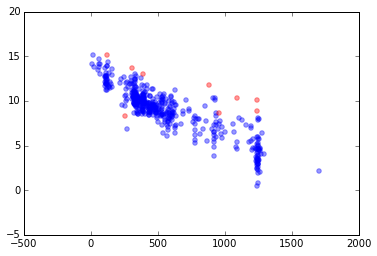

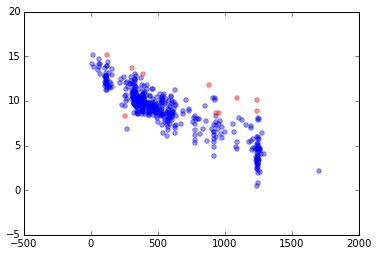

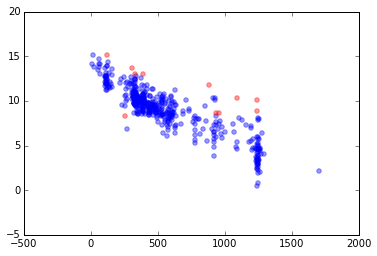

In [19]:
dists = X[:, 3]

def iterative_fit_parametric_outliers(X, ymeans, yvars, **kwargs):

    lbm = learn_parametric(X=X, y=ymeans, yvars=yvars, **kwargs)
    idx_bad_old = []
    for i in range(10):  
        diffs = score_all_points(lbm, X, ymeans, yvars)

        idx_good, = np.where(diffs > -2)
        idx_bad, = np.where(diffs <= -2)
        if len(idx_bad) == len(idx_bad_old) and (idx_bad==idx_bad_old).all():
            break

        plt.figure()
        plt.scatter(dists[idx_good], ymeans[idx_good], color="blue", alpha=0.4)
        plt.scatter(dists[idx_bad], ymeans[idx_bad], color="red", alpha=0.4)

        yvar_delta = np.zeros(yvars.shape)
        yvar_delta[idx_bad] = 100.0
        lbm = learn_parametric(X=X, y=ymeans, yvars=yvars+yvar_delta, **kwargs)
        idx_bad_old = idx_bad
    return lbm

lbm = iterative_fit_parametric_outliers(X, ymeans, yvars, sta="NV01", 
                       basisfn_str="sin1", noise_prior=noise_prior, optimize_marginal_ll=True)

# Travel time residuals

In [2]:
#%debug
r = get_training_data(runid=19, site="NV01", chan="SHZ", band="freq_0.8_4.5", phases=["Pg",], target="tt_residual",
                      require_human_approved=False, max_acost=np.inf,
                      min_amp=-10, array=False)
X, ymeans, yvars, evids = r

loading ['Pg'] fit data... 


In [5]:
import seaborn as sns

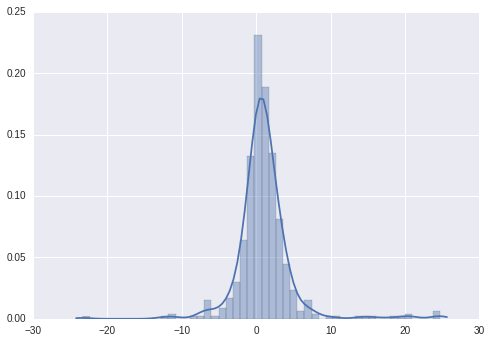

In [6]:
sns.distplot(ymeans)

Optimization terminated successfully.
         Current function value: 600.107845
         Iterations: 75
         Function evaluations: 140
got optimal laplacian 0.603209915 1.92403362854
Optimization terminated successfully.
         Current function value: 438.055031
         Iterations: 76
         Function evaluations: 143
got optimal laplacian 0.575180013832 1.12025150264
Optimization terminated successfully.
         Current function value: 429.429447
         Iterations: 73
         Function evaluations: 139
got optimal laplacian 0.583802035229 1.08956381096


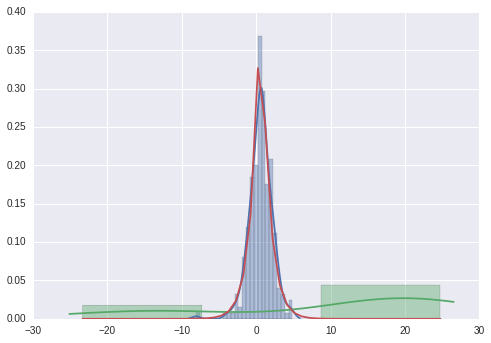

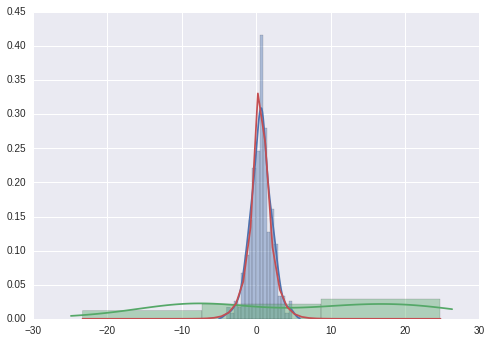

In [15]:
from sigvisa.learn.train_param_common import learn_constant_laplacian



def iterative_fit_laplace_outliers(X, ymeans, yvars, **kwargs):

    def score_laplace_points(cl, X, ymeans, yvars):
        uniform_lp = -np.log(np.max(ymeans) - np.min(ymeans))

        lp1s = []
        for (x, ym, yv) in zip(X, ymeans, yvars):
            x = x.reshape((1, -1))
            lp1 = cl.log_p(ym)
            lp1s.append(lp1)

        lp1s = np.array(lp1s).flatten()
        diffs = lp1s-uniform_lp
        return diffs
    
    idx_good, = np.where(yvars < 9.0)
        
    cl = learn_constant_laplacian(X[idx_good], ymeans[idx_good], **kwargs)
    
    idx_good_old = idx_good
    for i in range(10):  
        diffs = score_laplace_points(cl, X, ymeans, yvars)

        idx_good, = np.where( (diffs > -3) * (yvars < 9.0) )
        idx_bad, = np.where(diffs <= -3)
        if len(idx_good) == len(idx_good_old) and (idx_good==idx_good_old).all():
            break

        #plt.figure()
        #sns.distplot(ymeans[idx_good])
        #sns.distplot(ymeans[idx_bad])
        
        cl = learn_constant_laplacian(X[idx_good], ymeans[idx_good], **kwargs)
        
        #x = np.linspace(np.min(ymeans), np.max(ymeans))
        #lps = [cl.log_p(xx) for xx in x]
        #plt.plot(x, np.exp(lps))
        
        idx_good_old = idx_good
    return cl

noise_prior = LogNormal(0.5, 1.0)
cl = iterative_fit_laplace_outliers(X, ymeans, yvars, sta="NV01", noise_prior=noise_prior, optimize_marginal_ll=True)